In [ ]:
!git clone https://github.com/aqeelanwar/MaskTheFace.git

Cloning into 'MaskTheFace'...
remote: Enumerating objects: 3125, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3125 (delta 0), reused 0 (delta 0), pack-reused 3122
Receiving objects: 100% (3125/3125), 235.03 MiB | 29.06 MiB/s, done.
Resolving deltas: 100% (250/250), done.


In [ ]:
%cd MaskTheFace

/content/MaskTheFace


In [ ]:
!pip install -r requirements.txt

In [ ]:
import cv2
import os
import numpy as np
from IPython.display import Image as display_image
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, random_split
import glob
import sys
import random
import argparse
from PIL import Image, ImageFile
import face_recognition
from google.colab.patches import cv2_imshow

In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
def draw_sample(img_name):
  img_path = os.path.join("/content/MaskTheFace/out/masked/", img_name)
  mask_path = os.path.join("/content/MaskTheFace/out/segm/", img_name.rsplit(".")[0] + "_mask." + img_name.rsplit(".")[1])

  plt.figure(figsize=(16, 6))

  plt.subplot(1, 2, 1)
  plt.title("Изображение")
  plt.imshow(Image.open(img_path))
  plt.axis("off")

  plt.subplot(1, 2, 2)
  plt.title("Маска")
  plt.imshow(Image.open(mask_path))
  plt.axis("off")
  plt.show()

In [ ]:
!pip install autocrop

In [ ]:
from autocrop import Cropper

cropper = Cropper()

# Get a Numpy array of the cropped image
cropped_array = cropper.crop('/content/MaskTheFace/pic1.jpg')

# Save the cropped image with PIL if a face was detected:
if len(cropped_array):
    cropped_image = Image.fromarray(cropped_array)
    # cropped_image.save('cropped.png')

ImageReadError: ignored

In [ ]:
%cd MaskTheFace/

/content/MaskTheFace


In [ ]:
!mkdir out
!mkdir out/masked
!mkdir out/segm

In [ ]:
!rm -r crop

In [ ]:
!autocrop -i data -o crop -r reject -w 64 -H 64 -e png

In [ ]:
!python mask_for_segm.py

In [ ]:
np.random.uniform(low=0, high=1)

0.33907726703671237

In [ ]:
!python mask_the_face.py --path '/content/MaskTheFace/crop/03000.png' --out '/content/MaskTheFace' --mask_type 'surgical' --color 'green' --color_weight 0.33907726703671237 --verbose --write_original_image

 __  __           _ _______ _          ______
|  \/  |         | |__   __| |        |  ____|
| \  / | __ _ ___| | _| |  | |__   ___| |__ __ _  ___ ___
| |\/| |/ _` / __| |/ / |  | '_ \ / _ \  __/ _` |/ __/ _ \
| |  | | (_| \__ \   <| |  | | | |  __/ | | (_| | (_|  __/
|_|  |_|\__,_|___/_|\_\_|  |_| |_|\___|_|  \__,_|\___\___|
Masking image file
Faces found:  1
Processing Done


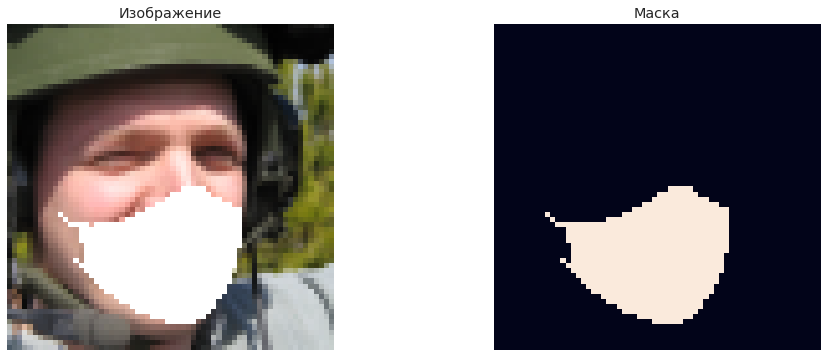

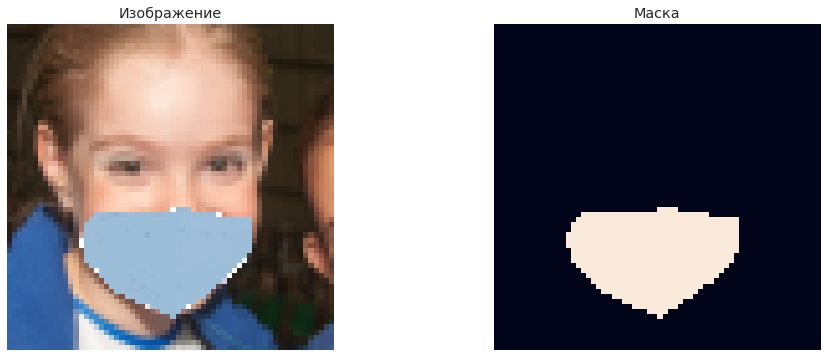

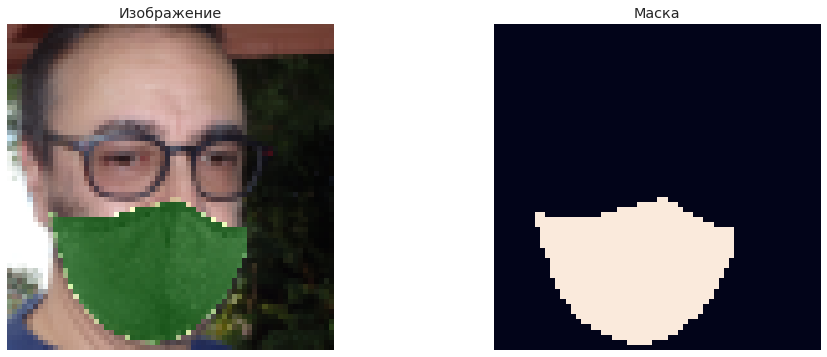

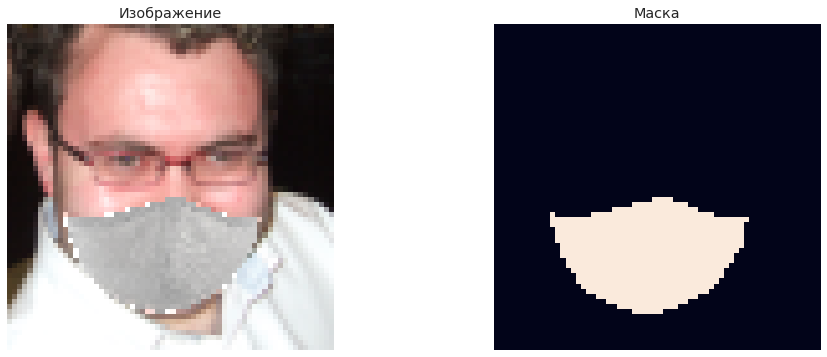

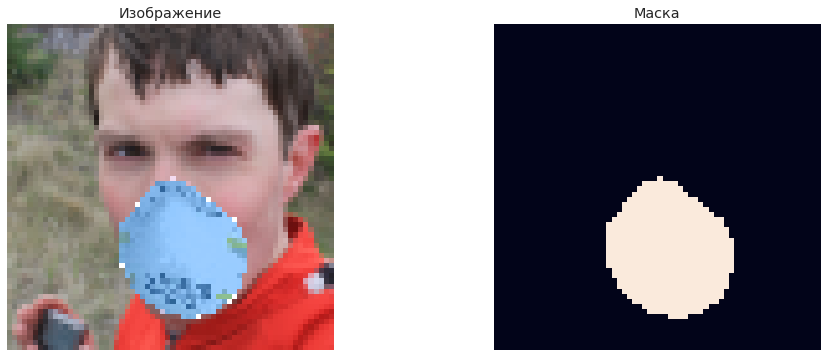

In [ ]:
image_names = glob.glob('/content/MaskTheFace/out/masked/*')
for imagename in image_names[-5:]:
  basename = imagename.split('/')[-1]
  draw_sample(basename)

In [ ]:
!zip -r /content/MaskTheFace/out.zip /content/MaskTheFace/out

In [ ]:
len(image_names)

1184

In [ ]:
import os
import time
import glob
import requests
from tqdm.notebook import tqdm
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split

import torch
from torch import nn
import torch.nn.functional as F

from sklearn.metrics import f1_score

import torchvision
from torchvision import datasets, transforms

from IPython.display import clear_output
%matplotlib inline

sns.set(font_scale=1.2, style='whitegrid')

# device_num = 0
# torch.cuda.set_device(device_num)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import subprocess
import torch
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F

from PIL import Image
from torch.utils.data import Dataset, random_split

In [ ]:
# Путь до zip-файла с даннными
ZIP_PATH = "/content/MaskTheFace/out.zip"

# Путь до папки с данными
DATA_PATH = "/content/MaskTheFace/out"

In [ ]:
class MaskDataset(Dataset):
    """ 
    Mask features dataset.  
    Override torch Dataset class to implements reading from h5 files
    """

    def __init__(self, data_path, mask_path, input_size=(64, 64)):
        """
        Args:
            data_path: путь до изображений.
            mask_path: путь до масок изображений.
        """
        self.data_path = data_path
        self.mask_path = mask_path

        # Файлы с изображениями и масками
        self.files = os.listdir(data_path)
        self.mask_files = os.listdir(self.mask_path)

        assert len(self.files) == len(self.mask_files)

        # Сортируем файлы, чтобы было соответствие
        # между изображениями и масками за счет порядка следования.
        self.files.sort()
        self.mask_files.sort()

        # Преобразование для изображений
        self.transform = transforms.Compose([                                
            transforms.Resize(input_size),
            transforms.ColorJitter(0.8, 0.8, 0.8, 0.5),
            transforms.ToTensor(),
        ])
        # Преобразование для масок
        self.transform_mask = transforms.Compose([
            transforms.Resize(input_size),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        # Загружаем изображение и маску
        file_name = os.path.join(self.data_path, self.files[idx])
        mask_name = os.path.join(self.mask_path, self.mask_files[idx])

        # Пробразуем изображение и маску
        input = self.transform(Image.open(file_name))
        target = self.transform_mask(Image.open(mask_name))

        # Приводим таргет/маску к такому виду, 
        # чтобы его значения были от 0 до 1
        target = (target > 0).long()

        return input, target

In [ ]:
# Датасет с данными для обучения и вадидации
dataset = MaskDataset(os.path.join(DATA_PATH, "masked"), 
                         os.path.join(DATA_PATH, "segm"))

# Разделение на обучающую и валидационную части
val_ratio = 0.2
data_len = len(dataset)
val_len = int(data_len * val_ratio)
train_len = data_len - val_len
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(
    dataset, lengths=(train_len, val_len), generator=generator)

# Тестовый датасет
# test_dataset = CarvanaDataset(os.path.join(DATA_PATH, "test"), 
#                          os.path.join(DATA_PATH, "test_masks"))

Значения в маске и количество значений: (array([0, 1]), array([3455,  641]))


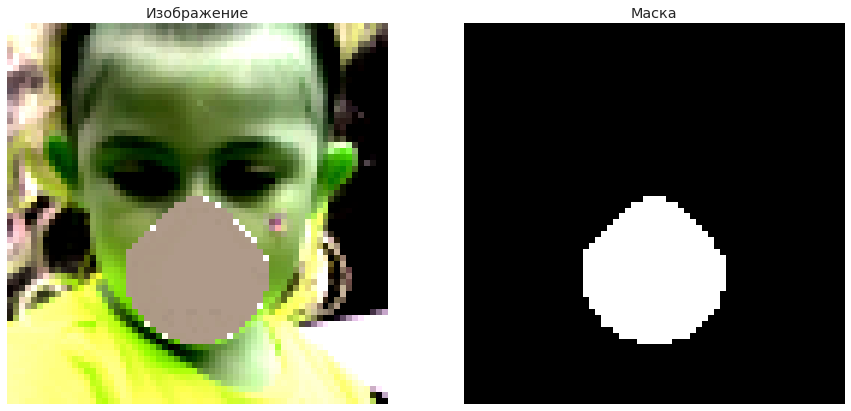

In [ ]:
i = 12

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title("Изображение")

plt.imshow(train_dataset[i][0].permute(1, 2, 0))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Маска")
plt.imshow(train_dataset[i][1].squeeze(), cmap='Greys_r')
plt.axis("off");

print("Значения в маске и количество значений:", np.unique(dataset[i][1], return_counts=True))

In [ ]:
segm_names = glob.glob('/content/MaskTheFace/out/segm/*')
masked_names = glob.glob('/content/MaskTheFace/out/masked/*')

In [ ]:
len(segm_names), len(masked_names)

(1586, 1586)

In [ ]:
for masked_name in masked_names:
  if not masked_name.replace('masked', 'segm').replace('.', '_mask.') in segm_names:
    print(masked_name)

In [ ]:
for segm_name in segm_names:
  if not np.all(np.unique(np.array(Image.open(segm_name))) == np.array([  0, 255])):
    print(segm_name)

In [ ]:
def iou(predicted_mask_batch, target_mask_batch):
    """ Считает IoU для всех элементов батча 
    Размер входа (размер батча, ширина, высота) """ 
    
    iou = np.logical_and(predicted_mask_batch, target_mask_batch).sum(axis=(1, 2)) / np.logical_or(predicted_mask_batch, target_mask_batch).sum(axis=(1, 2))
    return iou

In [ ]:
class ConvSeq(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1), # padding=1 ?
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.seq(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.seq = nn.Sequential(nn.MaxPool2d(2), ConvSeq(in_channels, out_channels))
        
    def forward(self, x):
        return self.seq(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvSeq(in_channels, out_channels)

    def forward(self, x, copy):
        x = self.up(x)
        concat = torch.cat([copy, x], dim=1)
        out = self.conv(concat)
        return out

In [ ]:
class MyUnet(nn.Module):
    def __init__(self):
        super(MyUnet, self).__init__()

        self.start = ConvSeq(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.finish = nn.Conv2d(64, 2, 1)

    def forward(self, input):
        layer1 = self.start(input)
        layer2 = self.down1(layer1)
        layer3 = self.down2(layer2)
        layer4 = self.down3(layer3)
        layer5 = self.down4(layer4)
        layer6 = self.up1(layer5, layer4)
        layer7 = self.up2(layer6, layer3)
        layer8 = self.up3(layer7, layer2)
        layer9 = self.up4(layer8, layer1)
        out = self.finish(layer9)
        return out

In [ ]:
def plot_learning_curves(history):
    '''
    Функция для вывода лосса и метрики во время обучения.

    :param history: (dict)
        accuracy и loss на обучении и валидации
    '''
    # sns.set_style(style='whitegrid')
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Лосс', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('IOU', fontsize=15)
    plt.plot(history['iou']['train'], label='train')
    plt.plot(history['iou']['val'], label='val')
    plt.ylabel('лосс', fontsize=15)
    plt.xlabel('эпоха', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
batch_size = 32

train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for X_batch, y_batch in train_batch_gen:
  print(X_batch.shape)
  break

torch.Size([32, 3, 64, 64])


In [ ]:
def train(
    model, 
    criterion,
    optimizer, 
    train_batch_gen,
    val_batch_gen,
    num_epochs=50,
    save_path=None,
    patience=5
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :param save_path: путь, куда сохранять модель

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0
        
        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True) 

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты на выходе модели
            logits = model(X_batch)
            
            # Подсчитываем лосс
            loss = criterion(logits, y_batch.squeeze(1).to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()
            
            # Сохраяняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += iou(y_batch.cpu().numpy().squeeze(1), y_pred).mean()

        # Подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen) 
        history['loss']['train'].append(train_loss)
        history['iou']['train'].append(train_acc)
    
        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False) 

        # Полный проход по валидации    
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Логиты, полученные моделью
            logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.squeeze(1).to(device))

            # Сохраяняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += iou(y_batch.cpu().numpy().squeeze(1), y_pred).mean()
            

        # Подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen) 
        history['loss']['val'].append(val_loss)
        history['iou']['val'].append(val_acc)
        
        clear_output()

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))
        
        plot_learning_curves(history)

        if save_path is not None:
          torch.save({
          'epoch': epoch,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'history': dict(history),
          }, save_path)
      
        
    return model, history

In [ ]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)

cuda


In [ ]:
model = MyUnet()

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd content/

[Errno 2] No such file or directory: 'content/'
/content/MaskTheFace


In [ ]:
# !mkdir drive/MyDrive/masks_off/models

Epoch 100 of 100 took 6.571s
  training loss (in-iteration): 	0.021881
  validation loss (in-iteration): 	0.025158
  training accuracy: 			95.58 %
  validation accuracy: 			94.89 %


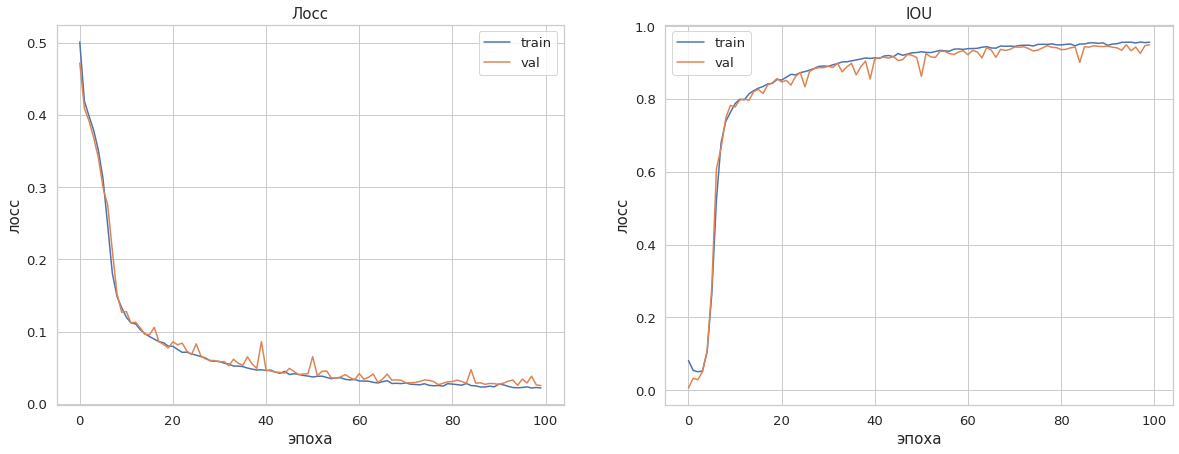

In [ ]:
model, history = train(
    model, criterion, optimizer, 
    train_batch_gen, val_batch_gen, 
    num_epochs=100,
    save_path='/content/drive/MyDrive/masks_off/models/unet_depth_4_color_jitter'
)

In [ ]:
!mkdir test

In [ ]:
!mv '/content/MaskTheFace/temp.jpg' 'test/test.jpg'

In [ ]:
image_url = 'https://www.narescue.com/pub/media/catalog/product/cache/6c9c2a8706ce872329c582c5a62c8bc4/z/z/zz-1352_i.jpg'
import urllib.request

with urllib.request.urlopen(image_url) as url:
    with open(f'/content/MaskTheFace/test/url_{image_url[-10:]}.jpg', 'wb') as f:
        f.write(url.read())

In [ ]:
!autocrop -i test -o test_crop -r reject -w 64 -H 64 -e png

Processing images in folder: /content/MaskTheFace/test
Face detected:    /content/MaskTheFace/test_crop/url_96x522.jpg.png
No face detected: /content/MaskTheFace/reject/url_A&usqp=CAU.jpg
No face detected: /content/MaskTheFace/reject/url_6d3cd7.jpg.jpg
Face detected:    /content/MaskTheFace/test_crop/url_k&usqp=CAU.png
Face detected:    /content/MaskTheFace/test_crop/url_sk.4b0.jpg.png
Face detected:    /content/MaskTheFace/test_crop/test.png
Face detected:    /content/MaskTheFace/test_crop/url_1352_i.jpg.png
No face detected: /content/MaskTheFace/reject/url_0x2000.jpg.jpg
8 : Input files, 5 : Faces Cropped, 3


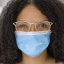

In [ ]:
Image.open('/content/MaskTheFace/test_crop/url_k&usqp=CAU.png')

In [ ]:
def apply_model(model, img_path):
  input_size=(64, 64)
  transform = transforms.Compose([                                
              transforms.Resize(input_size),
              transforms.ToTensor(),
          ])

  input = transform(Image.open(img_path))
  input = input.reshape((1, 3, 64, 64)).to(device)

  logits = model(input)
  y_pred = logits.max(1)[1].detach().cpu().numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(input.cpu().squeeze().permute(1, 2, 0))
  plt.imshow(y_pred.squeeze(), cmap='Greys_r', alpha=0.5)
  return y_pred.squeeze()

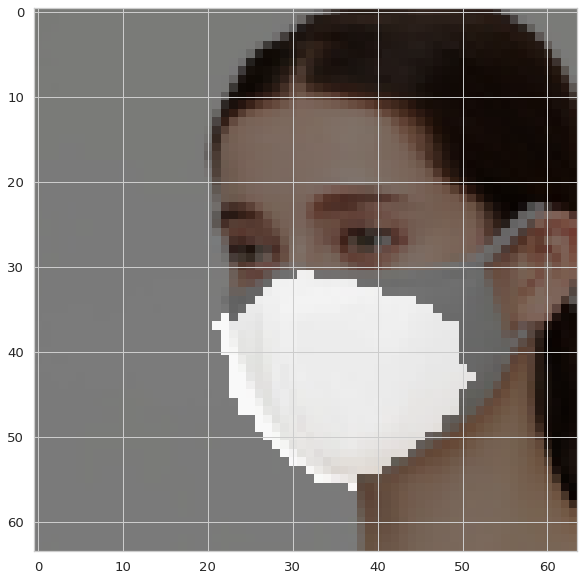

In [ ]:
apply_model(model, '/content/MaskTheFace/test_crop/url_96x522.jpg.png')

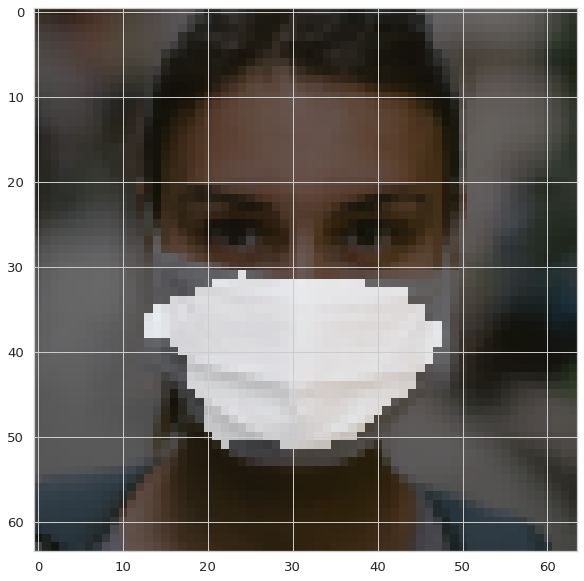

In [ ]:
apply_model(model, '/content/MaskTheFace/test_crop/url_sk.4b0.jpg.png')

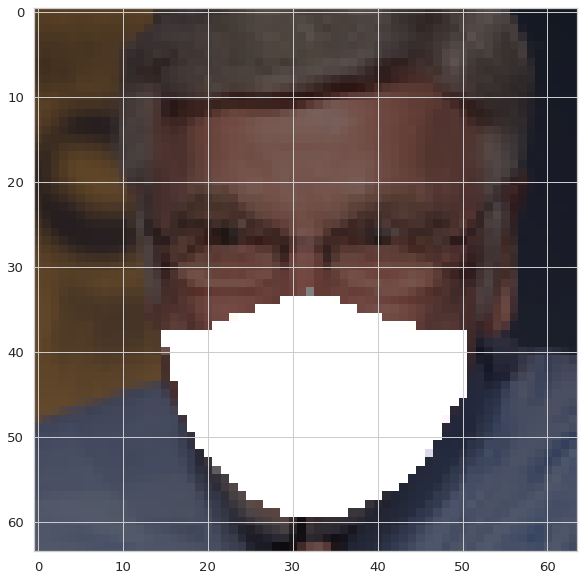

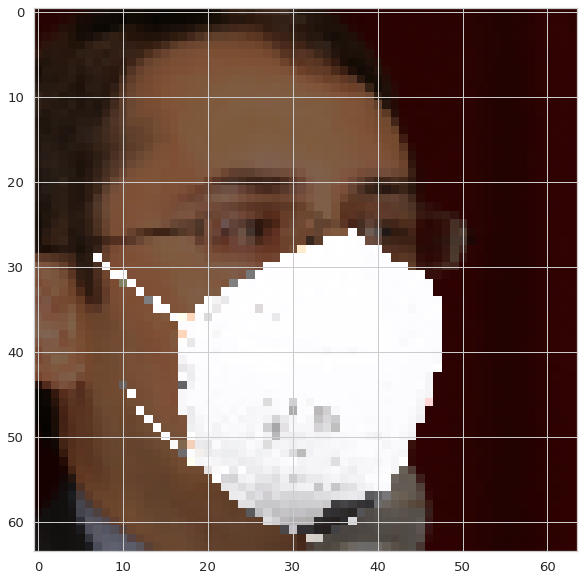

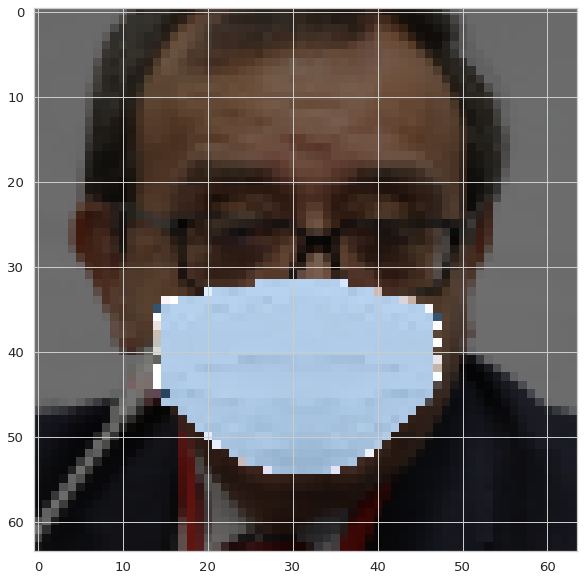

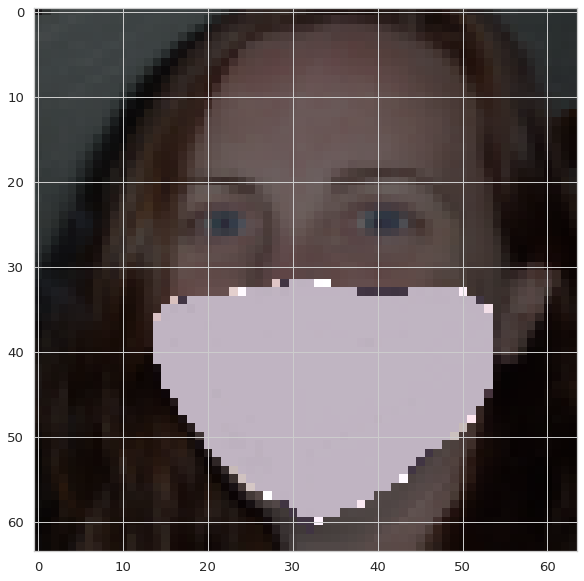

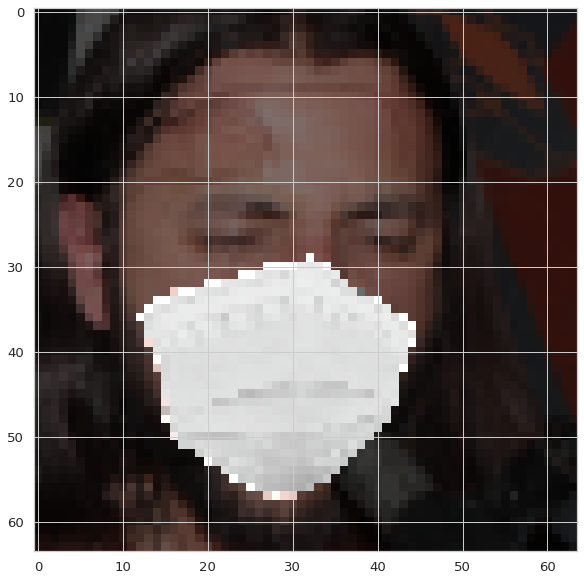

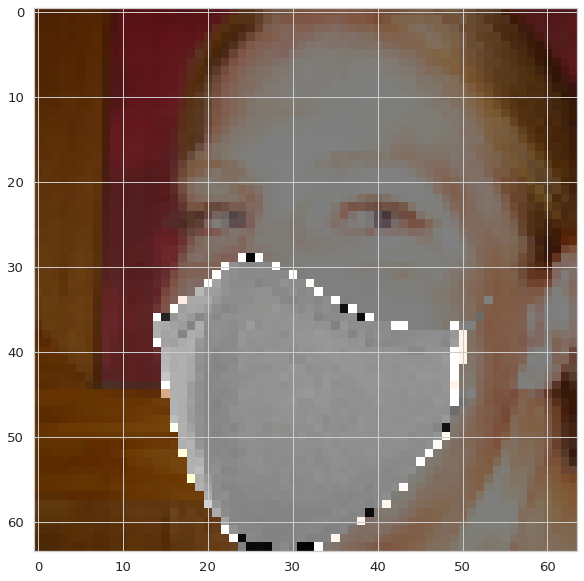

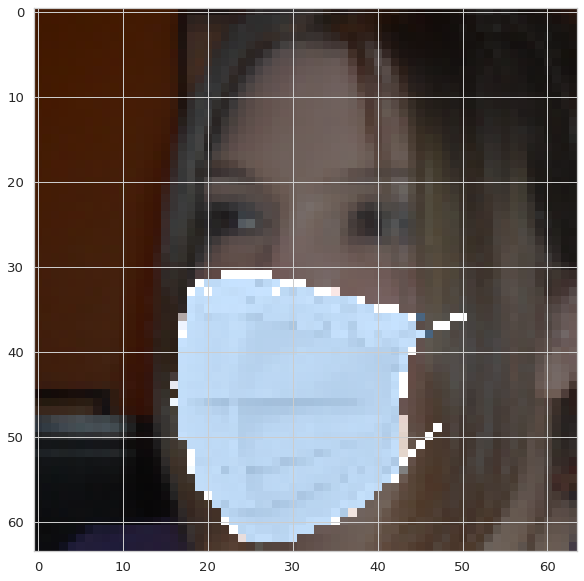

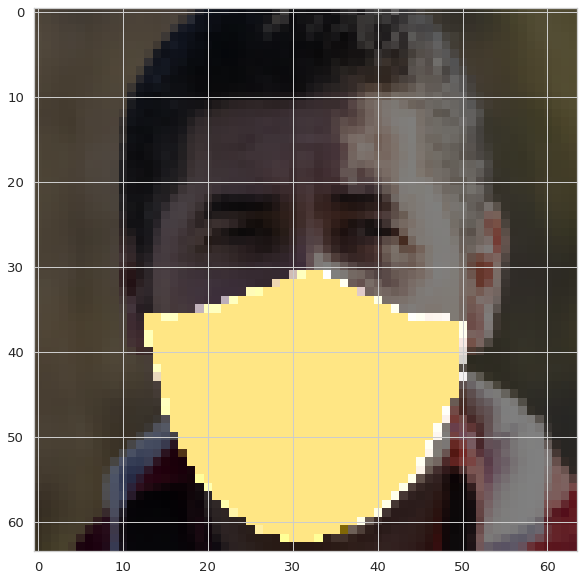

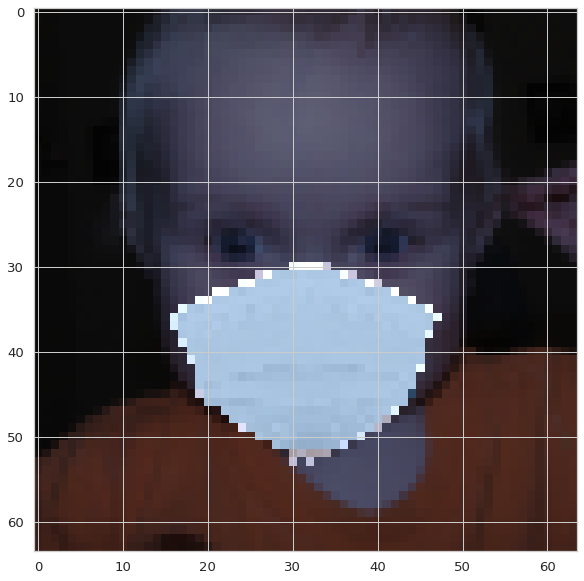

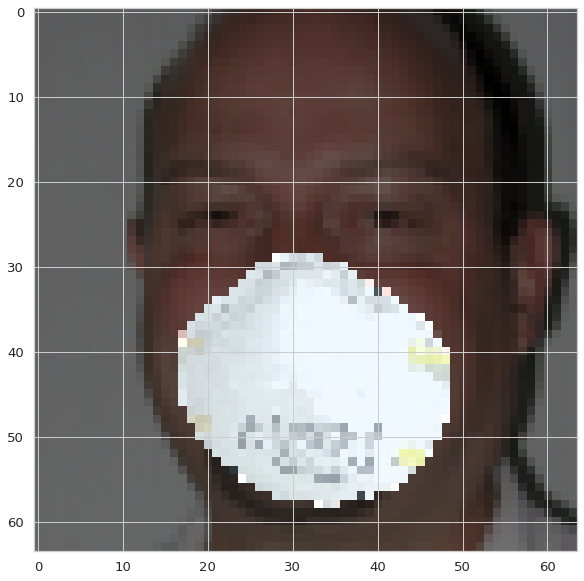

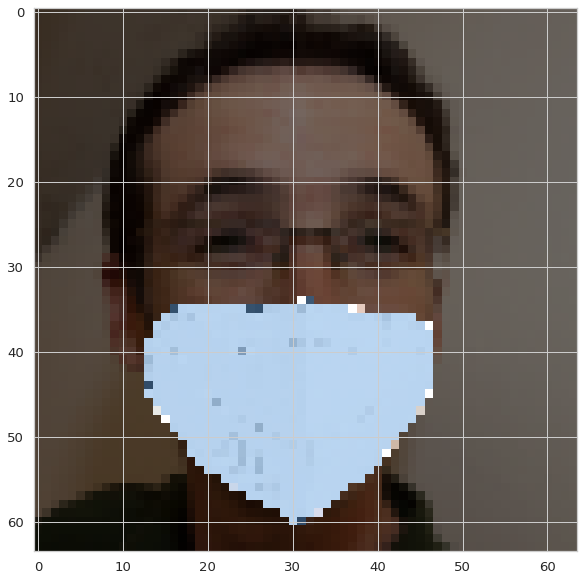

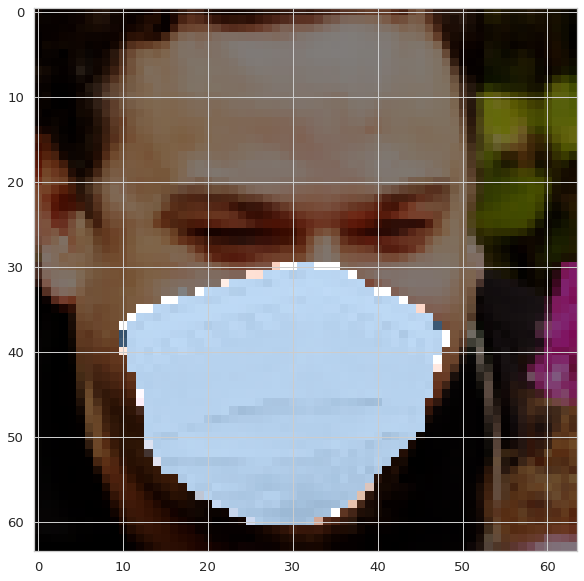

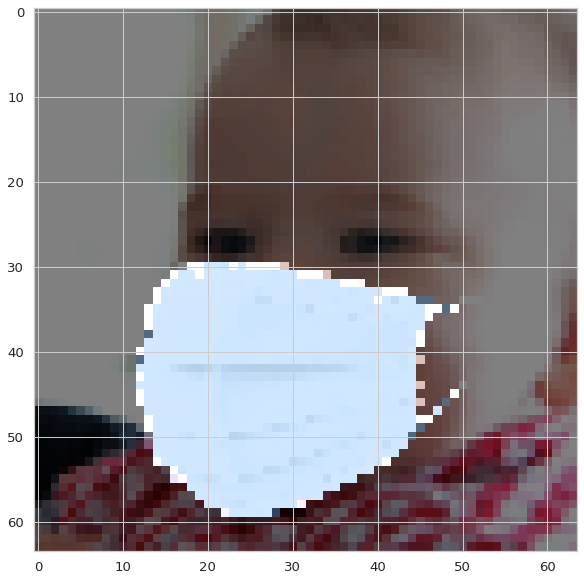

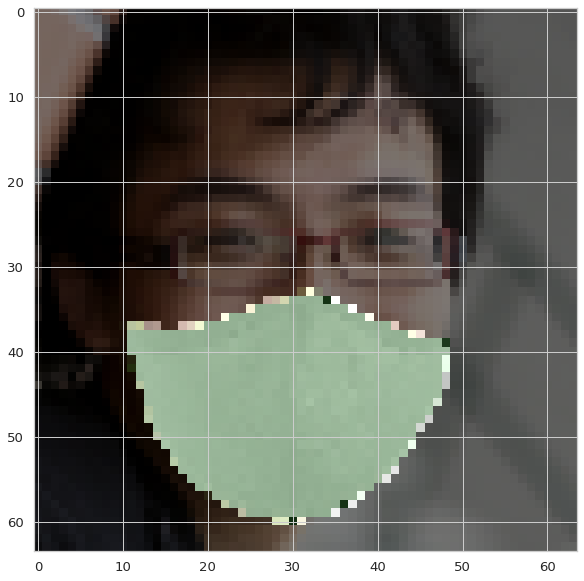

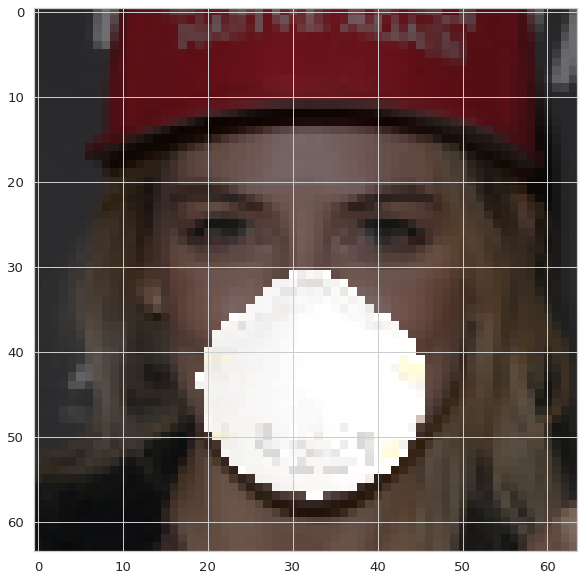

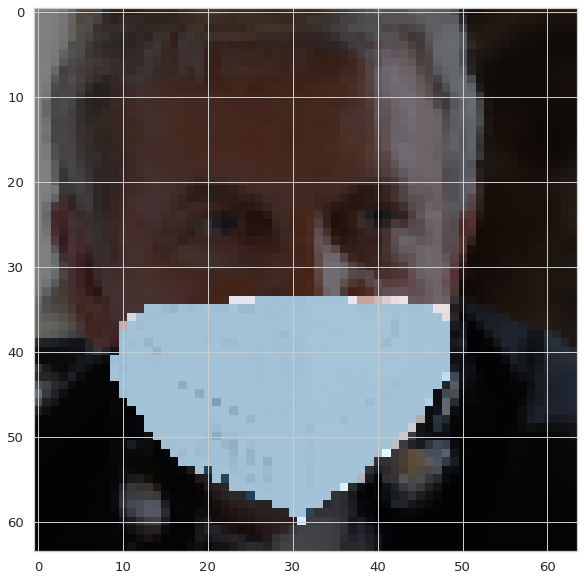

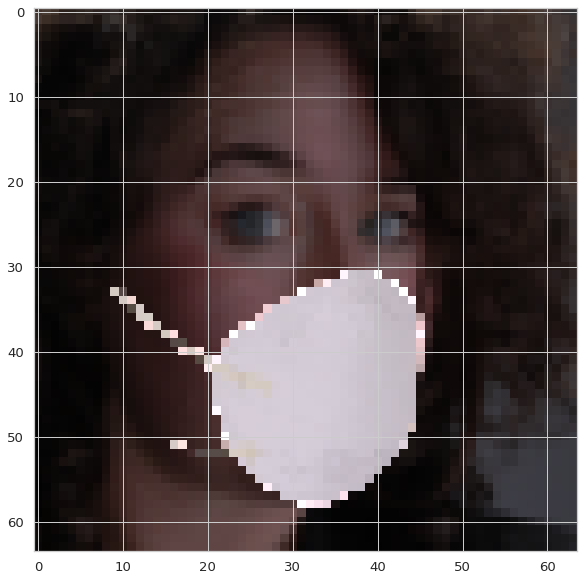

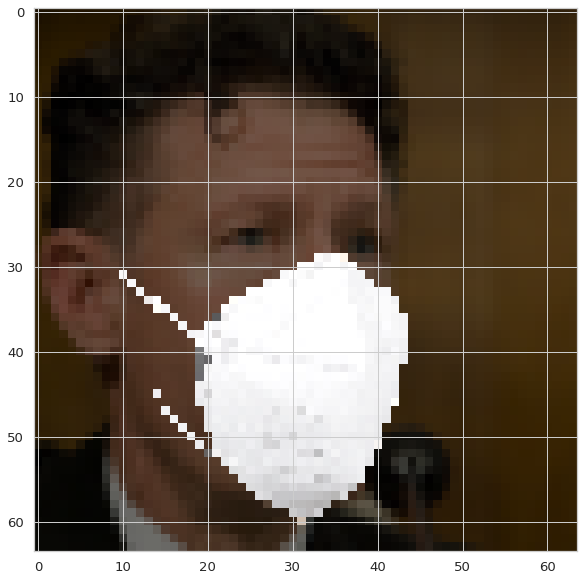

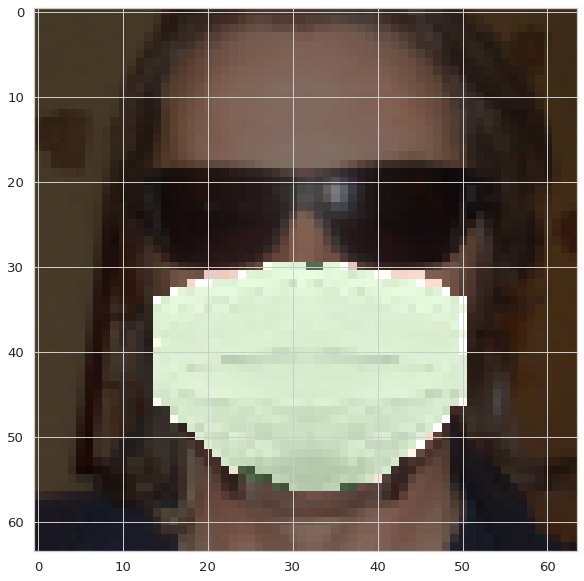

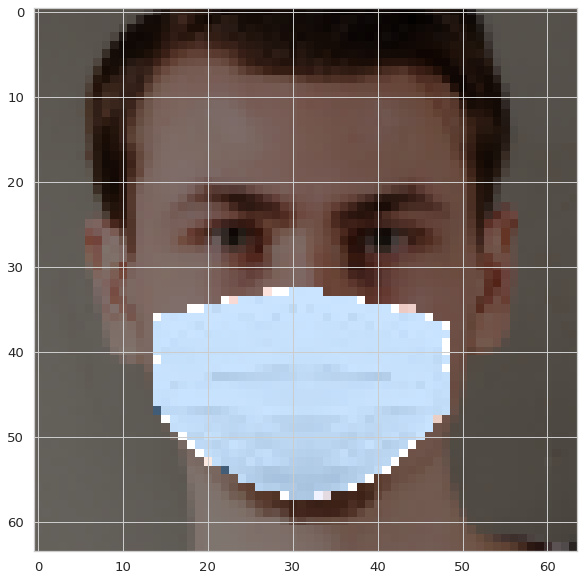

In [ ]:
test_names = glob.glob('/content/MaskTheFace/test_crop')
for imagename in image_names:
  apply_model(model, imagename)

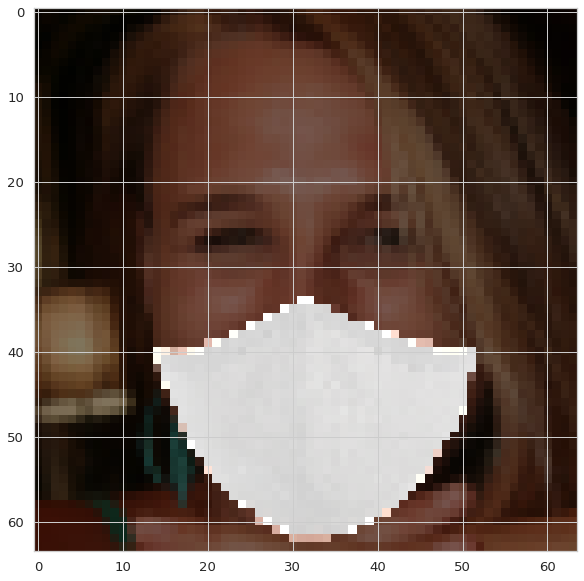

In [ ]:
sample = apply_model(model, '/content/MaskTheFace/out/masked/00001_cloth.png')

# Inpaint libraries

In [ ]:
!pip install pyamg

     |████████████████████████████████| 749 kB 7.1 MB/s 
  Created wheel for pyamg: filename=pyamg-4.1.0-cp37-cp37m-linux_x86_64.whl size=7781618 sha256=8e7b012a88cbd150a85012b64df975e832739f4c7678b38451d4cfd2aef5476e
  Stored in directory: /root/.cache/pip/wheels/64/77/6f/2117a1d8d3c9b2d5e3d0f18476658bd6db1ced0395b251eac0
Successfully built pyamg


In [ ]:
!pip install Pillow

In [ ]:
!pip install scipy==1.2.0
import scipy as sps
print(sps.__version__)

     |████████████████████████████████| 26.6 MB 1.2 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kapre 0.3.5 requires numpy>=1.18.5, but you have numpy 1.18.4 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


1.4.1


In [ ]:
!pip install tensorflow==1.15.0
import tensorflow as tf
print(tf.__version__)

     |████████████████████████████████| 412.3 MB 23 kB/s 
     |████████████████████████████████| 3.8 MB 70.5 MB/s 
     |████████████████████████████████| 503 kB 59.4 MB/s 
     |████████████████████████████████| 50 kB 9.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=abb01619fefc13d7d5fc032869469eddc72e8ba14da1295ece5a53ee8f592609
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

# Inpaint

In [ ]:
%cd ..

/content


In [ ]:
!unzip semantic_image_inpainting.zip

In [ ]:
%cd semantic_image_inpainting/

/content/semantic_image_inpainting


In [ ]:
!mkdir completions

In [ ]:
!mkdir samples
!mkdir samples/mask
!mkdir samples/face

In [ ]:
!cp '/content/MaskTheFace/out/masked/00001_cloth.png' '/content/semantic_image_inpainting/samples/face/00001_cloth.png'

In [ ]:
Image.fromarray(np.array(sample - 1, np.uint8)).save('/content/semantic_image_inpainting/samples/mask/00001_cloth.png')

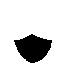

In [ ]:
Image.open('/content/semantic_image_inpainting/samples/mask/00001_cloth.png')

In [ ]:
!python src/inpaint.py --model_file graphs/dcgan-100.pb \
    --maskType file \
    --maskFile '/content/semantic_image_inpainting/samples/mask/00001_cloth.png' \
    --in_img '/content/semantic_image_inpainting/samples/face/00001_cloth.png' \
    --nIter 100 --blend

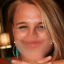

In [ ]:
display_image(filename='/content/semantic_image_inpainting/completions/inpaint_0.png')

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
img_arr = load_images_from_folder('completions')

In [ ]:
def image_grid(array, ncols=8):
    index, height, width, channels = array.shape
    nrows = index//ncols
    
    array = array[:nrows*ncols]
    img_grid = (array.reshape(nrows, ncols, height, width, channels)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, channels))
    
    return img_grid

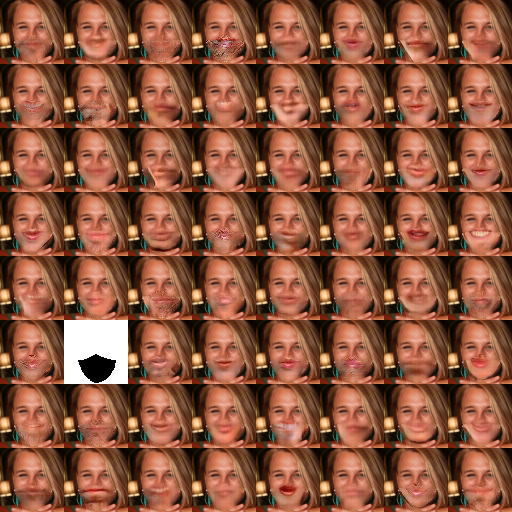

In [ ]:
result = image_grid(np.array(img_arr))
cv2_imshow(result)